In [26]:
# %%
# Imports
import os
import numpy as np
import seaborn as sns
import polars as pl
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tensorflow as tf
import matplotlib.pyplot as plt


In [27]:
# %%
# Load data
def get_file_path(file_name):
    path = f"{file_name}"
    if not os.path.exists(path):
        path = f"/your_code/{path}"
    return path


def set_random_seed(seed):
    # Sets random seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


extra_features = input(
    "Type 128 to use 128-feature node embeddings (must be computed locally, not in repository), or press enter to use 16-feature embeddings: "
)

print("This is a node embedding matrix of each node in the graph - X features for prediction")
if extra_features == "128": # Polars automatically handles compression
    X_df = pl.read_csv(get_file_path("Data/precomputed_node_embeddings_128.gz")) # Node embeddings
else:
    X_df = pl.read_csv(get_file_path("Data/precomputed_node_embeddings.gz"))
print(X_df.head())

user_df = pl.read_csv(get_file_path("Data/precomputed_scores.gz")) # Calculated broker/source spreader scores

print("This is a dataframe of the calculated broker/source spreader scores - Y target for prediction")
print(user_df.head())

This is a node embedding matrix of each node in the graph - X features for prediction
shape: (5, 128)
┌───────────┬───────────┬───────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ 0         ┆ 1         ┆ 2         ┆ 3         ┆ … ┆ 124      ┆ 125       ┆ 126       ┆ 127       │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64      ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ -0.000012 ┆ 0.001237  ┆ -0.000929 ┆ -0.003082 ┆ … ┆ -0.00221 ┆ 0.001573  ┆ 0.003246  ┆ -0.000879 │
│ -0.001472 ┆ -0.007436 ┆ -0.007803 ┆ -0.007529 ┆ … ┆ 0.000465 ┆ 0.0009    ┆ -0.007064 ┆ -0.006532 │
│ 0.384376  ┆ 0.024383  ┆ 0.238242  ┆ -0.129099 ┆ … ┆ 0.052466 ┆ -0.216833 ┆ 0.099861  ┆ -0.256144 │
│ -0.313972 ┆ -0.204895 ┆ 0.169171  ┆ -0.02241  ┆ … ┆ 0.200435 ┆ -0.086627 ┆ 0.7030668 ┆ -

In [28]:
# %%
# Train-test split
Y = pl.Series(user_df["broker_score"])
X_train, X_test, Y_train, Y_test = train_test_split(
    X_df, Y, train_size=0.9, shuffle=True, random_state=0
)
Y_train: pl.DataFrame = Y_train.to_frame()
Y_test: pl.DataFrame = Y_test.to_frame()

bins = [-float("inf"), 0, 25, 100, 500, 10000, float("inf")]
labels = [0, 1, 2, 3, 4, 5]

Y_train = Y_train.with_columns(pl.Series(name="index", values=range(len(Y_train))))
high_value_indices = Y_train.filter(pl.col("broker_score") >= 10000)["index"]
medium_value_indices = Y_train.filter((pl.col("broker_score") >= 500) & (pl.col("broker_score") < 10000))["index"]
low_value_indices = Y_train.filter(pl.col("broker_score") < 10000)["index"]

In [29]:
# Perform PCA to reduce dimensions to 2
n = -1 # 50000 # Was 81 seconds for 50,000, now 34 seconds
if n == -1:
    X_df_trimmed = X_df
    n = len(X_df)
else:
    X_df_trimmed = X_df.head(n)
pca = PCA(n_components=2)
pca_50 = PCA(n_components=10)
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1, max_iter=250)
X_df_pca = pca.fit_transform(X_df_trimmed.to_numpy())
X_df_pca = pl.DataFrame(X_df_pca, schema=["PC1", "PC2"])

if os.path.exists("Data/precomputed_node_embeddings_tsne.gz"):
    X_df_tsne = pl.read_csv("Data/precomputed_node_embeddings_tsne.gz")
else:
    X_df_tsne = tsne.fit_transform(pca_50.fit_transform(X_df_trimmed.to_numpy()))
    X_df_tsne = pl.DataFrame(X_df_tsne, columns=['TSNE1', 'TSNE2'])
    X_df_tsne.write_csv('Data/precomputed_node_embeddings_tsne.gz')

# Add a column to indicate high broker score
X_df_pca = X_df_pca.with_columns(pl.Series(name="High_Broker_Score", values=user_df['broker_score'].head(n) > 10000))
X_df_tsne = X_df_tsne.with_columns(pl.Series(name="High_Broker_Score", values=user_df['broker_score'].head(n) > 10000))

print(X_df_tsne.head())

shape: (5, 3)
┌───────────┬───────────┬───────────────────┐
│ TSNE1     ┆ TSNE2     ┆ High_Broker_Score │
│ ---       ┆ ---       ┆ ---               │
│ f64       ┆ f64       ┆ bool              │
╞═══════════╪═══════════╪═══════════════════╡
│ 3.1501496 ┆ 0.42827   ┆ false             │
│ 3.2321892 ┆ 0.5616664 ┆ false             │
│ -3.13864  ┆ -1.345006 ┆ false             │
│ -2.32143  ┆ -1.695703 ┆ false             │
│ -2.057602 ┆ -1.821031 ┆ true              │
└───────────┴───────────┴───────────────────┘


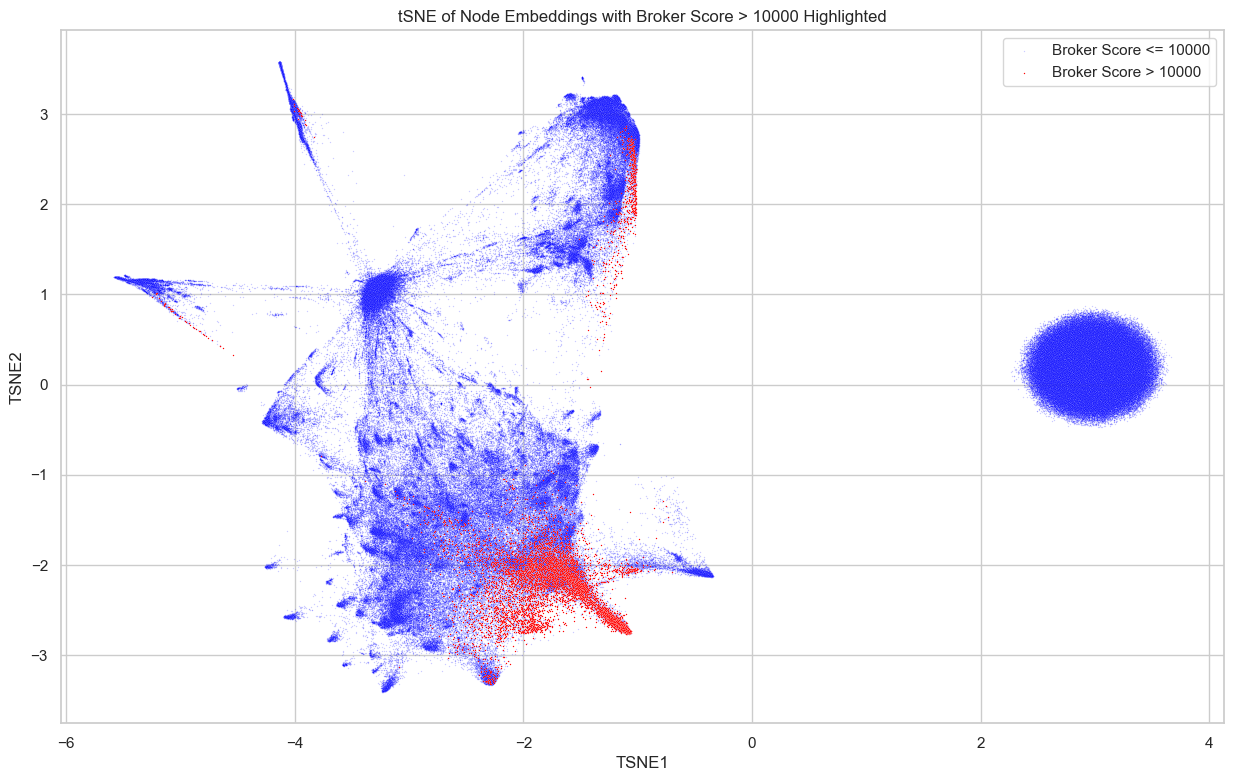

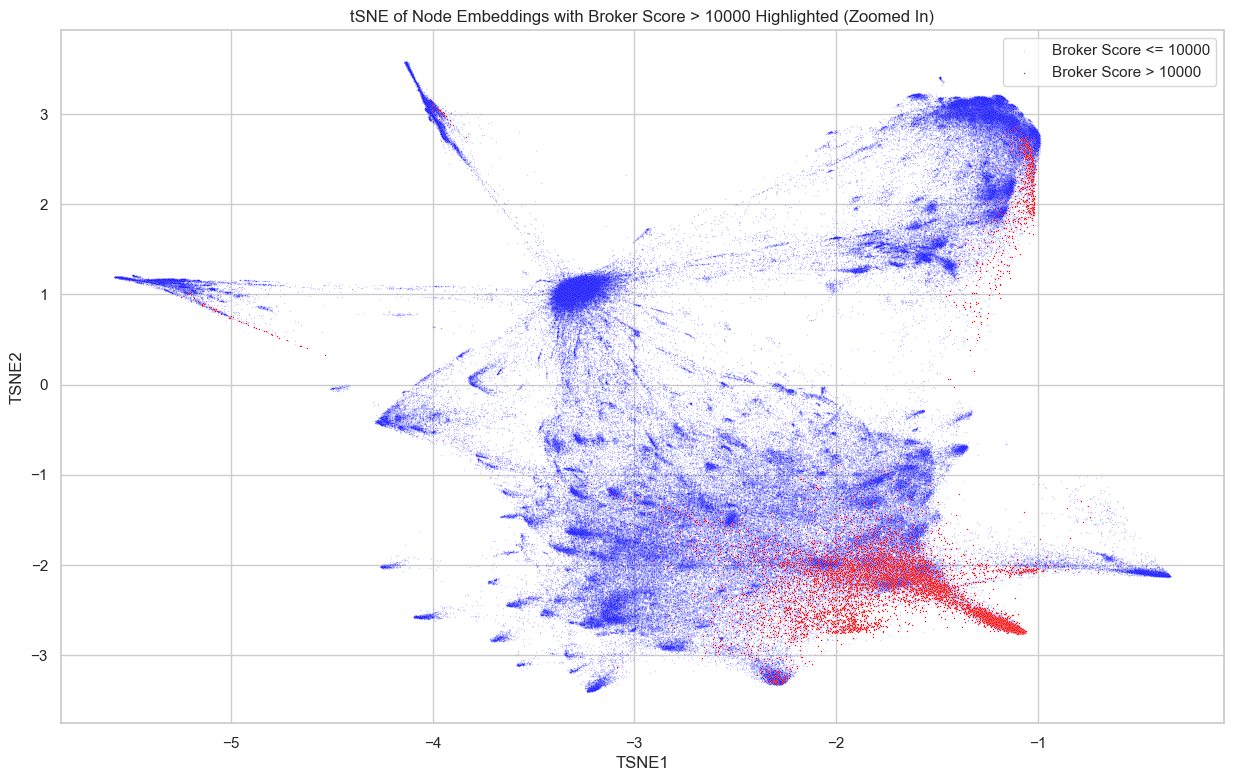

In [41]:
# Plot using seaborn
plt.figure(figsize=(15, 9))
sns.set_theme(style="whitegrid")
sns.scatterplot(data=X_df_tsne.filter(~X_df_tsne["High_Broker_Score"]), x='TSNE1', y='TSNE2', color='blue', label='Broker Score <= 10000', s=1, alpha=0.2)
sns.scatterplot(data=X_df_tsne.filter(X_df_tsne["High_Broker_Score"]), x='TSNE1', y='TSNE2', color='red', label='Broker Score > 10000', s=1, alpha=1.0)
plt.title('tSNE of Node Embeddings with Broker Score > 10000 Highlighted')
plt.legend()
plt.show()

X_df_tsne_filtered = X_df_tsne.filter((pl.col("TSNE1") <= 0))
plt.figure(figsize=(15, 9))
sns.set_theme(style="whitegrid")
sns.scatterplot(data=X_df_tsne_filtered.filter(~X_df_tsne_filtered["High_Broker_Score"]), x='TSNE1', y='TSNE2', color='blue', label='Broker Score <= 10000', s=1, alpha=0.2)
sns.scatterplot(data=X_df_tsne_filtered.filter(X_df_tsne_filtered["High_Broker_Score"]), x='TSNE1', y='TSNE2', color='red', label='Broker Score > 10000', s=1, alpha=1.0)
plt.title('tSNE of Node Embeddings with Broker Score > 10000 Highlighted (Zoomed In)')
plt.legend()
plt.show()

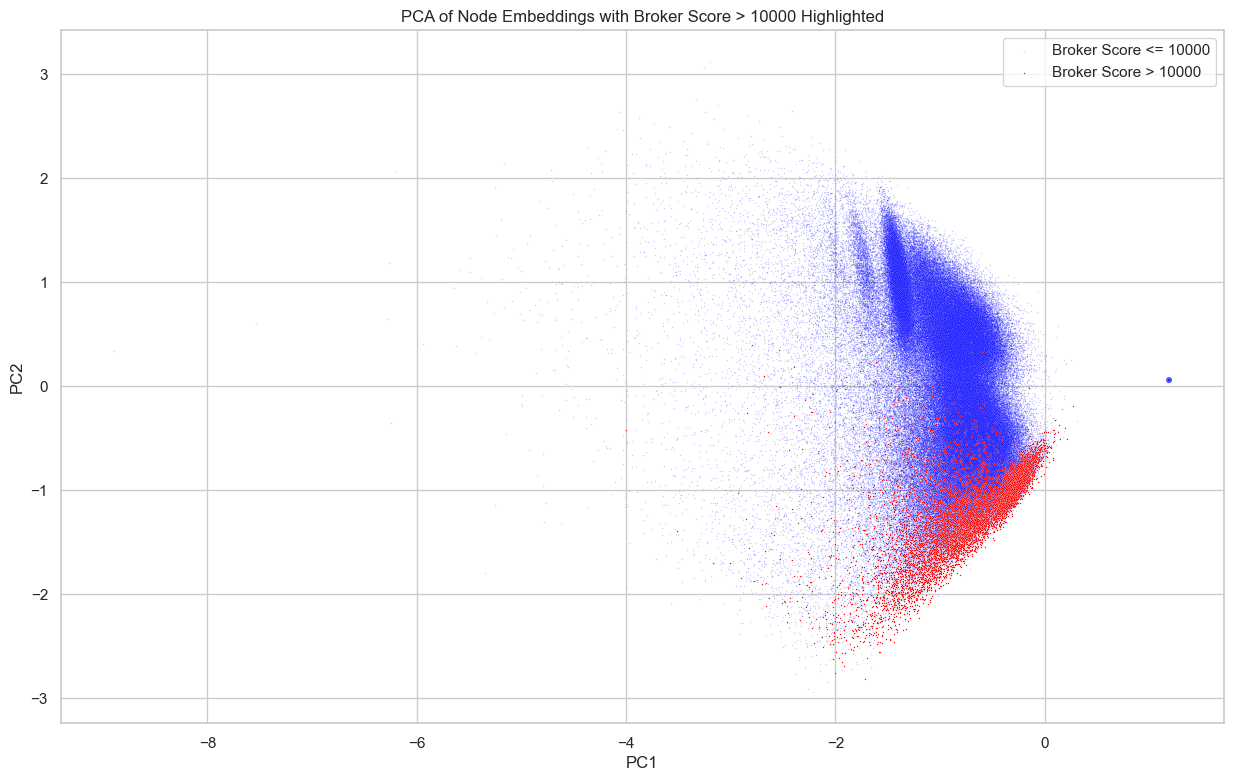

In [38]:
# Plot using seaborn
plt.figure(figsize=(15, 9))
sns.set_theme(style="whitegrid")
sns.scatterplot(data=X_df_pca.filter(~X_df_pca["High_Broker_Score"]), x='PC1', y='PC2', color='blue', label='Broker Score <= 10000', s=1, alpha=0.2)
sns.scatterplot(data=X_df_pca.filter(X_df_pca["High_Broker_Score"]), x='PC1', y='PC2', color='red', label='Broker Score > 10000', s=1, alpha=1.0)
plt.title('PCA of Node Embeddings with Broker Score > 10000 Highlighted')
plt.legend()
plt.show()